In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import statistics

## Helper functions!

In [48]:
# define function to compute test MSEs
def comp_mse(model, temp_data):
    predictions = model.predict(temp_data)
    mse_test = np.mean((temp_data['Withdraw']-predictions)**2)    
    return mse_test

## Read the data

In [49]:
# Read the data
data=pd.read_csv('ATM_sample.csv')
data.head()

# Define target variable
y = data['Withdraw']

# Define the input variables
X = data.drop(columns=['Withdraw'])

X.columns

Index(['Shops', 'ATMs', 'Downtown', 'Weekday', 'Center', 'High'], dtype='object')

## Alter the input columns (X) as you see fit

The following example adds combination variables split on downtown.

In [50]:
X_temp = X.drop(columns=['Downtown']).mul(X['Downtown'], axis=0).rename(columns={'Shops': "Shops_DT", 'ATMs': "ATMs_DT", 'Weekday': "Weekday__DT", 'Center': 'Center_DT', 'High': "High_DT"})  

X_temp['Downtown_NotWeekday_Center'] = X['Downtown'] * (1 - X['Weekday'] ) * X['Center']
X_temp["Shops_DWC"] = X_temp['Downtown_NotWeekday_Center'] * X['Shops'] 

In [51]:
X_new = pd.concat([X_temp,X], axis=1)
X_new.head()

,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT,Downtown_NotWeekday_Center,Shops_DWC,Shops,ATMs,Downtown,Weekday,Center,High
0,1018,10,0,0,0,0,0,1018,10,1,0,0,0
1,974,10,1,0,0,0,0,974,10,1,1,0,0
2,0,0,0,0,0,0,0,96,2,0,0,0,1
3,958,9,1,0,1,0,0,958,9,1,1,0,1
4,0,0,0,0,0,0,0,103,4,0,1,0,1


## Run model with ALL the added input variables

This is an optional step so we can see the base line model results. We can examine the p variables to determine which variables should be excluded.

In [52]:
# Preprocess the data
# 1. Separate the data into training and test data
# 2. Fit the scaling to the training data and apply to both the train and test data 

# Define columns to scale
columns_to_scale = ['ATMs', 'ATMs_DT', 'Shops', 'Shops_DWC', 'Shops_DT']

# 1. Separate
X_train, X_test, y_train, y_test = train_test_split(
    X_new,              # Features
    y,                  # Target variable
    test_size=0.2,      # 20% for testing, 80% for training
    random_state=1      # Set for reproducibility
)

train = pd.concat([y_train,X_train], axis=1)
test = pd.concat([y_test,X_test], axis=1)

# 2. Scale
scaler = StandardScaler().fit(train[columns_to_scale]) 

train[columns_to_scale] = scaler.transform(train[columns_to_scale])
test[columns_to_scale] = scaler.transform(test[columns_to_scale]) 

train.head()


,Withdraw,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT,Downtown_NotWeekday_Center,Shops_DWC,Shops,ATMs,Downtown,Weekday,Center,High
7214,71.451101,0.629417,0.807052,1,1,1,0,-0.145495,0.627193,0.830934,1,1,1,1
13522,64.949936,0.546223,0.397534,1,0,0,0,-0.145495,0.534761,0.286455,1,1,0,0
18479,70.265111,0.640364,0.192776,1,0,1,0,-0.145495,0.639356,0.014215,1,1,0,1
3366,70.693183,0.655689,0.602293,1,0,1,0,-0.145495,0.656382,0.558694,1,1,0,1
21645,16.757929,-1.540207,-1.445294,0,0,0,0,-0.145495,-1.508474,-1.346982,0,1,0,0


In [53]:
# 3. Model
formula = f'Withdraw ~ {" + ".join(X_train.columns)}'  

model = ols(formula, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
model.summary()

Test MSE:  0.2695266206747369
Train MSE:  0.2714184057389415


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.127e+06
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:10:55   Log-Likelihood:                -13497.
No. Observations:               17600   AIC:                         2.702e+04
Df Residuals:                   17586   BIC:                         2.713e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     89.2510      0.193    462.688      0.000      88.873      89.629
Shops_DT                      41.7966      0.660     63.334      0.000      40.503      43.090
ATMs_DT                       -0.0516      0.036     -1.436      0.151      -0.122       0.019
Weekday__DT                    0.2242      0.019     11.631      0.000       0.186       0.262
Center_DT                     -0.5763      0.030    -19.130      0.000      -0.635      -0.517
High_DT                       -0.0506      0.019     -2.696      0.007      -0.087      -0.014
Downtown_NotWeekday_Center    -2.6218      1.360     -1.927      0.054      -5.288       0.044
Shops_DWC                      3.2196      0.194     16.610      0.000       2.840       3.599
Shops                          7.6182      0.586     12.998      0.000       6.469       8.767
ATMs                          -3.6402      0.026   -141.858      0.000      -3.690      -3.590
Downtown                     -47.7605      0.277   -172.508      0.000     -48.303     -47.218
Weekday                       -2.2179      0.016   -140.101      0.000      -2.249      -2.187
Center                         3.5909      0.024    150.689      0.000       3.544       3.638
High                           1.0376      0.016     65.921      0.000       1.007       1.068
==============================================================================
Omnibus:                       65.191   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.187
Skew:                           0.113   Prob(JB):                     3.48e-16
Kurtosis:                       3.214   Cond. No.                         725.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note: the MSE is already lower!

Looking at the p values, we should exclude variables `ATMs_DT` and `High_DT` from the model.


## Best Subset selection!

AIC, BIC, test MSE all used. An interesting feature might be to change the train test split.

In [54]:
# Initialize lists to store metrics
aic = []
bic = []
p = []
test_mse = []

# Start time measurement
start_time = time.time()

count = 1

# Null model with just the intercept
formula = 'Withdraw ~ 1'
model = ols(formula, data=train).fit()
aic.append(model.aic)
bic.append(model.bic)
test_mse.append(comp_mse(model, test))
p.append(1)

# Initialize best metrics with the null model
best_aic = model.aic
best_bic = model.bic
best_model_aic = formula
best_model_bic = formula
best_p_aic = 1
best_p_bic = 1
best_test_mse = test_mse[-1]
best_model_test_mse = formula

# Iterate over all combinations of predictors
for i in range(1, len(X_train.columns) + 1):

    # Reintialise best_train_mse for each i
    best_train_mse = np.inf 

    for combo in itertools.combinations(X_train.columns, i):
        # Create the model formula
        formula = f'Withdraw ~ {" + ".join(combo)}'
        model = ols(formula, data=train).fit()
        train_mse = comp_mse(model, train)

        # Store the AIC, BIC, and number of parameters using append
        aic.append(model.aic)
        bic.append(model.bic)
        p.append(i + 1)
        
        # Update best AIC model if current model is better
        if model.aic < best_aic:
            best_model_aic = formula
            best_aic = model.aic
            best_p_aic = i + 1 
        
        # Update best BIC model if current model is better
        if model.bic < best_bic:
            best_model_bic = formula
            best_bic = model.bic
            best_p_bic = i + 1 

        count += 1

        #use train MSE to select the best set for a given number of predictors i
        if train_mse < best_train_mse:
            best_model_train_mse = formula
            best_model_fit_train_mse = model
            best_train_mse = train_mse

    # once the best set was found for given i compute test mse
    test_mse.append(comp_mse(best_model_fit_train_mse, test))

    # Update best model based on test_mse if current model is better
    if test_mse[-1] < best_test_mse:
        best_model_test_mse = best_model_train_mse
        best_test_mse = test_mse[-1]
        best_p_test = i + 1

    end_time = time.time()
    elapsed_time = end_time - start_time

# Output the best model
print(f"Best subset selection took {count} iterations and {elapsed_time:.2f} seconds. Best model based on each statistic is as follows (includes intercept):")
print(f"AIC={best_aic:.2f} with {best_p_aic} parameters:\n {best_model_aic}\n")
print(f"BIC={best_bic:.2f} with {best_p_bic} parameters:\n {best_model_bic}\n") 
print(f"test MSE: {best_test_mse:.2f} has {best_p_test} parameters:\n {best_model_test_mse}")

Best subset selection took 8192 iterations and 234.27 seconds. Best model based on each statistic is as follows (includes intercept):
AIC=27022.59 with 14 parameters:
 Withdraw ~ Shops_DT + ATMs_DT + Weekday__DT + Center_DT + High_DT + Downtown_NotWeekday_Center + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High

BIC=27115.04 with 11 parameters:
 Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High

test MSE: 0.27 has 11 parameters:
 Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High


<Axes: >

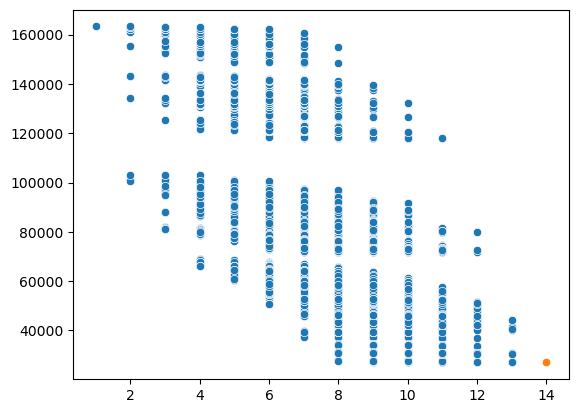

In [55]:
sns.scatterplot(x=p, y=aic)
sns.scatterplot(x=[best_p_aic], y=[best_aic]) # note here we plot just one point, but we need to pass is as list, hence the []

<Axes: >

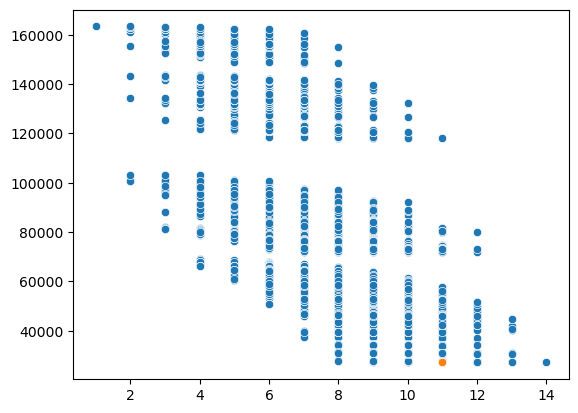

In [56]:
sns.scatterplot(x=p, y=bic)
sns.scatterplot(x=[best_p_bic], y=[best_bic]) # note here we plot just one point, but we need to pass is as list, hence the []

<Axes: >

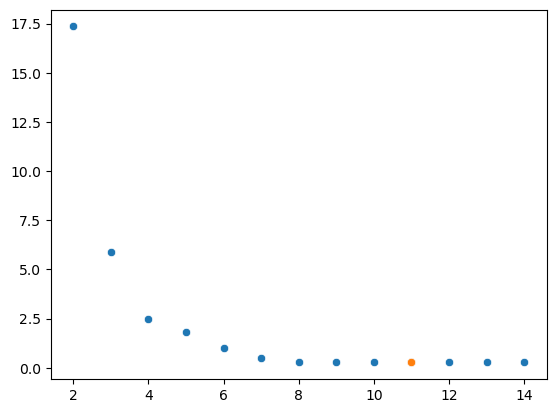

In [57]:
sns.scatterplot(x=range(1+1, len(train.columns) + 1),y=test_mse[1:])
sns.scatterplot(x=[best_p_test], y=[best_test_mse]) # note here we plot just one point, but we need to pass is as list, hence the []

In [58]:
# 3. AIC Best Model
formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops + ATMs + Downtown + Weekday + Center + High"

model = ols(formula, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
# model.summary()

Test MSE:  5.539436110324526
Train MSE:  5.5297063672162485


In [65]:
# BIC Best Model
# Train MSE Best Model
#formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High"
formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Downtown_NotWeekday_Center + Shops + ATMs + Downtown + Weekday + Center + High"
model = ols(formula, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
model.summary()

Test MSE:  0.2766548410857211
Train MSE:  0.27450717420842313


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.016e+06
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:26:51   Log-Likelihood:                -13597.
No. Observations:               17600   AIC:                         2.722e+04
Df Residuals:                   17589   BIC:                         2.730e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     89.2655      0.194    460.733      0.000      88.886      89.645
Shops_DT                      42.6258      0.665     64.113      0.000      41.323      43.929
Weekday__DT                    0.2079      0.019     10.722      0.000       0.170       0.246
Center_DT                     -0.5477      0.030    -18.238      0.000      -0.607      -0.489
Downtown_NotWeekday_Center    19.9494      0.034    579.538      0.000      19.882      20.017
Shops                          7.0504      0.591     11.936      0.000       5.893       8.208
ATMs                          -3.6717      0.008   -452.668      0.000      -3.688      -3.656
Downtown                     -48.4079      0.275   -175.999      0.000     -48.947     -47.869
Weekday                       -2.2064      0.016   -138.435      0.000      -2.238      -2.175
Center                         3.5590      0.024    149.384      0.000       3.512       3.606
High                           0.9997      0.009    115.999      0.000       0.983       1.017
==============================================================================
Omnibus:                       68.119   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.184
Skew:                           0.117   Prob(JB):                     7.78e-17
Kurtosis:                       3.215   Cond. No.                         426.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
# Train MSE Best Model
formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + High_DT + Shops + ATMs + Downtown + Weekday + Center + High"
model = ols(formula, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
# model.summary()

Test MSE:  5.540336098006683
Train MSE:  5.5290411111444175


Doing some manual cross validation checking to assess if doing cross validation is necessary

In [69]:
test_mse = []

for i in range(1,21):
    columns_to_scale = ['ATMs', 'ATMs_DT', 'Shops','Shops_DT']

    # 1. Separate
    X_train, X_test, y_train, y_test = train_test_split(
        X_new,              # Features
        y,                  # Target variable
        test_size=0.2,      # 20% for testing, 80% for training
        random_state=i      # Set for reproducibility
    )

    train = pd.concat([y_train,X_train], axis=1)
    test = pd.concat([y_test,X_test], axis=1)

    # 2. Scale
    scaler = StandardScaler().fit(train[columns_to_scale]) 

    train[columns_to_scale] = scaler.transform(train[columns_to_scale])
    test[columns_to_scale] = scaler.transform(test[columns_to_scale]) 
    
    # AIC 
    formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Downtown_NotWeekday_Center + Shops + ATMs + Downtown + Weekday + Center + High"

    # BIC
    #formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High"
    model = ols(formula, data=train).fit()
    test_mse.append(comp_mse(model, test)) 

print("With Downtown_NotWeekday_Center: ")   
print(f"Mean : {statistics.mean(test_mse)}")
print(f"Max: {max(test_mse)}")
print(f"Min: {min(test_mse)}")

With Downtown_NotWeekday_Center: 
Mean : 0.27465621144847063
Max: 0.28875464710119125
Min: 0.2676433158297687


From these, we can see that it is a pretty stable result, thus, I don't think it is necessary to perform cross validation on the model selection. 

In [71]:
test_mse = []

for i in range(1,51):
    columns_to_scale = ['ATMs', 'ATMs_DT', 'Shops','Shops_DT']

    # 1. Separate
    X_train, X_test, y_train, y_test = train_test_split(
        X_new,              # Features
        y,                  # Target variable
        test_size=0.2,      # 20% for testing, 80% for training
        random_state=i      # Set for reproducibility
    )

    train = pd.concat([y_train,X_train], axis=1)
    test = pd.concat([y_test,X_test], axis=1)

    # 2. Scale
    scaler = StandardScaler().fit(train[columns_to_scale]) 

    train[columns_to_scale] = scaler.transform(train[columns_to_scale])
    test[columns_to_scale] = scaler.transform(test[columns_to_scale]) 
    
    formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High"
    model = ols(formula, data=train).fit()
    test_mse.append(comp_mse(model, test)) 

print("With Shops_DWC: ")   
print(f"Mean : {statistics.mean(test_mse)}")
print(f"Max: {max(test_mse)}")
print(f"Min: {min(test_mse)}")

With Shops_DWC: 
Mean : 0.27222615832375213
Max: 0.2863120254605196
Min: 0.2613048473441674


In [72]:
test_mse = []

for i in range(1,51):
    columns_to_scale = ['ATMs', 'ATMs_DT', 'Shops','Shops_DT']

    # 1. Separate
    X_train, X_test, y_train, y_test = train_test_split(
        X_new,              # Features
        y,                  # Target variable
        test_size=0.2,      # 20% for testing, 80% for training
        random_state=i      # Set for reproducibility
    )

    train = pd.concat([y_train,X_train], axis=1)
    test = pd.concat([y_test,X_test], axis=1)

    # 2. Scale
    scaler = StandardScaler().fit(train[columns_to_scale]) 

    train[columns_to_scale] = scaler.transform(train[columns_to_scale])
    test[columns_to_scale] = scaler.transform(test[columns_to_scale]) 
     
    formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Downtown_NotWeekday_Center + Shops + ATMs + Downtown + Weekday + Center + High"
    model = ols(formula, data=train).fit()
    test_mse.append(comp_mse(model, test)) 

print("With Downtown_NotWeekday_Center: ")   
print(f"Mean : {statistics.mean(test_mse)}")
print(f"Max: {max(test_mse)}")
print(f"Min: {min(test_mse)}")

With Downtown_NotWeekday_Center: 
Mean : 0.27616959155328186
Max: 0.28875464710119125
Min: 0.265049376389136
